In [11]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import torch

In [12]:
dir = "../inputs/JSON/"

In [13]:
def countNumCones(dir):
    blue_cone_count_total = 0
    yellow_cone_count_total = 0

    for tracks in os.listdir(dir):
        if tracks.endswith(".json"):
            tracks_path = os.path.join(dir, tracks)
            with open(tracks_path, 'r') as file:
                json_data = json.load(file)

            # Extract x and y coordinates for blue and yellow cones
            x_blue = [json_data["x"][i] for i, color in enumerate(json_data["color"]) if color == "blue"]
            y_blue = [json_data["y"][i] for i, color in enumerate(json_data["color"]) if color == "blue"]
            x_yellow = [json_data["x"][i] for i, color in enumerate(json_data["color"]) if color == "yellow"]
            y_yellow = [json_data["y"][i] for i, color in enumerate(json_data["color"]) if color == "yellow"]

            # Count blue and yellow cones in the current file
            blue_cone_count_total += len(x_blue)
            yellow_cone_count_total += len(x_yellow)

        # Print total counts
        print(f"Total number of blue cones in {tracks}: {blue_cone_count_total}")
        print(f"Total number of yellow cones in {tracks}: {yellow_cone_count_total}")
        print("--------------------------------------------------------")

countNumCones(dir)



Total number of blue cones in track1.json: 111
Total number of yellow cones in track1.json: 105
--------------------------------------------------------
Total number of blue cones in track2.json: 266
Total number of yellow cones in track2.json: 254
--------------------------------------------------------
Total number of blue cones in track3.json: 353
Total number of yellow cones in track3.json: 335
--------------------------------------------------------


In [14]:
def findClosestBlue(yellow_x, yellow_y, x_blue, y_blue):
    distances = [distance.euclidean((yellow_x, yellow_y), (blue_x, blue_y)) for blue_x, blue_y in zip(x_blue, y_blue)]
    closest_blue_index = distances.index(min(distances))
    return x_blue[closest_blue_index], y_blue[closest_blue_index]

In [15]:
def calculateMidpoints(yellow_x, yellow_y, x_blue, y_blue):
    division_factors = [1, 2, 3]  # You can add more values if needed
    midpoints = []

    for factor in division_factors:
        closest_blue_x, closest_blue_y = findClosestBlue(yellow_x, yellow_y,x_blue, y_blue)
        midpoint_x = (yellow_x + closest_blue_x) / factor
        midpoint_y = (yellow_y + closest_blue_y) / factor
        midpoints.append((midpoint_x, midpoint_y))

    # Choose the midpoint that is most in the middle
    middle_index = len(midpoints) // 2  # Index of the middle value
    return midpoints[middle_index]

In [16]:
def plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=4)
    plt.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=4)
    plt.plot(x_path, y_path, marker='', linestyle='-', color='black', label='Path')

    # Customize plot if needed
    plt.title('Midpoints between Blue and Yellow Cones')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [17]:
def generateSrcTgt():
    count = 0
    src = pd.DataFrame()
    tgt = pd.DataFrame()
    print("Showing Sample Data: ")
    for tracks in os.listdir(dir):
        if tracks.endswith(".json"):
            tracks = os.path.join(dir, tracks)
            #print(tracks)
            with open(tracks, 'r') as file:
                json_data = json.load(file)
            json_data["color"][0] = "blue"
            x_blue = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
            y_blue = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
            x_yellow = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
            y_yellow = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
            # make last point of yellow as first point to make it a closed loop
            x_yellow.append(x_yellow[0])
            y_yellow.append(y_yellow[0])
            x_path, y_path = zip(*[calculateMidpoints(yellow_x, yellow_y,x_blue,y_blue) for yellow_x, yellow_y in zip(x_yellow, y_yellow)])
            x_path = list(x_path)
            y_path = list(y_path)
            
            # Add extra midpoints to the path when needed
            for i in range(1, len(x_path), 2):
                # Take the midpoint between 2 different midpoints each time and add them to the array of midpoints
                if len(x_path) < len(x_blue):
                    x_midpoint = (x_path[i - 1] + x_path[i]) / 2
                    y_midpoint = (y_path[i - 1] + y_path[i]) / 2
                    x_path.insert(i, x_midpoint)
                    y_path.insert(i, y_midpoint)
                    #print(len(x_path))
                    #print(len(x_blue))
                else:
                    break
            midpoints = pd.DataFrame(list(zip(x_path, y_path)), columns=['x_target', 'y_target'])
            
            if count < 4:
                plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)                    
                count += 1
            
            src = pd.concat([src, pd.read_json(tracks)], axis=0)
            tgt = pd.concat([tgt, midpoints], axis=0)
            src.reset_index(drop=True, inplace=True)
            tgt.reset_index(drop=True, inplace=True)
    colors = pd.get_dummies(src['color'])
    src = pd.concat([src, colors], axis=1)
    src.drop('color', axis=1, inplace=True)
    src = torch.tensor(src.values, dtype=torch.float32)
    tgt = torch.tensor(tgt.values, dtype=torch.float32)
    print("Data loaded successfully!")
    return src, tgt

Showing Sample Data: 


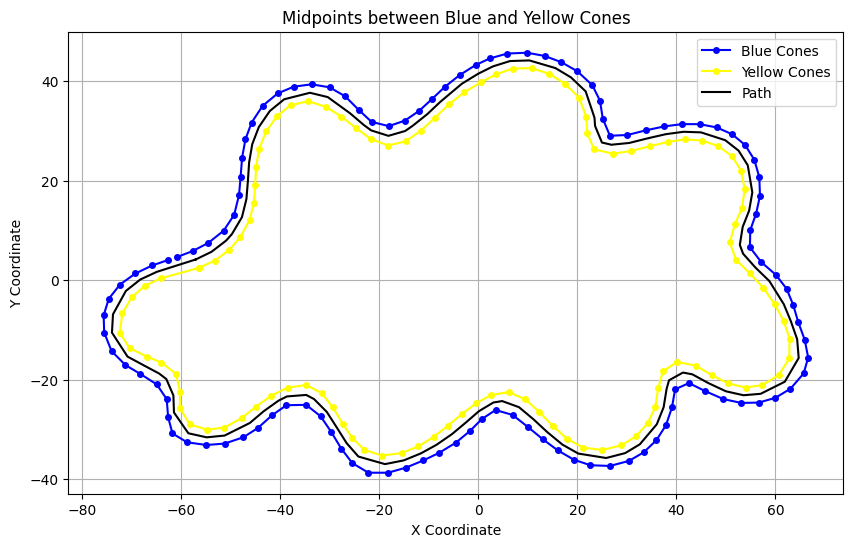

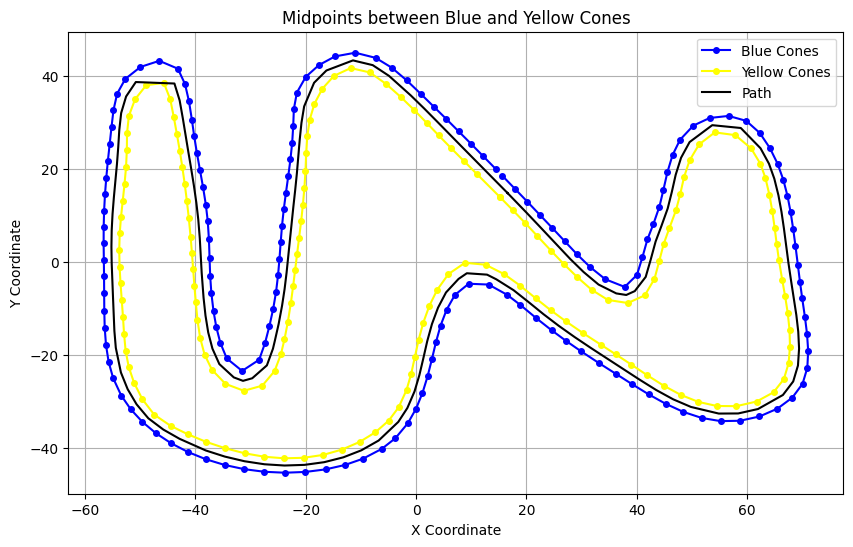

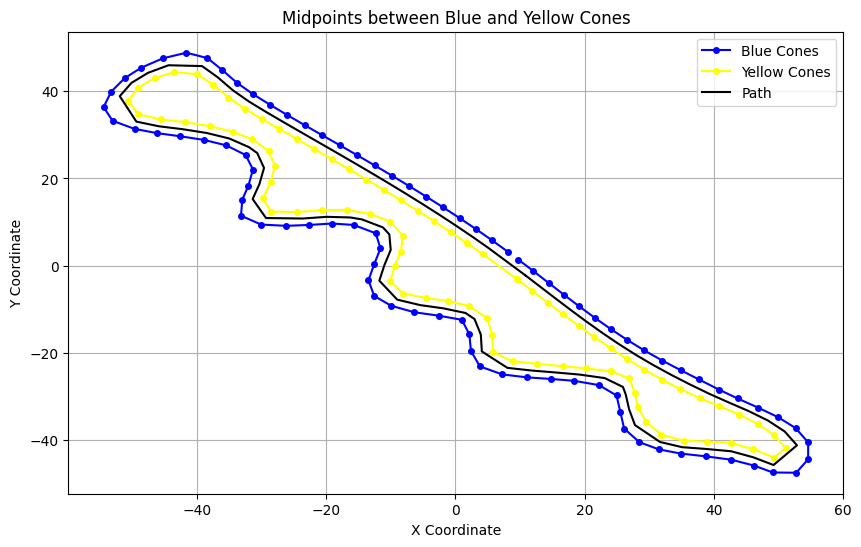

Data loaded successfully!


In [18]:
src,tgt = generateSrcTgt()

In [19]:
src.shape, tgt.shape

(torch.Size([694, 5]), torch.Size([356, 2]))

In [20]:
# save the data
torch.save(src, '../inputs/tensors/src.pt')
torch.save(tgt, '../inputs/tensors/tgt.pt')